# Домашняя работа 11. Прогнозирование методом fbprophet

Вариант benzak_02.

Лазарев Эдуард Артемович
N33471

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

#  Читаем данные
df = pd.read_csv('benzak_02.csv', sep=';')
df.head(14)

,date,total_items_sold
0,2146-01-01,5893.0
1,2146-01-02,8245.0
2,2146-01-03,8906.0
3,2146-01-04,9385.0
4,2146-01-05,10006.0
5,2146-01-06,9819.0
6,2146-01-07,7169.0
7,2146-01-08,10057.0
8,2146-01-09,10036.0
9,2146-01-10,9281.0


Переименнуем столбцы в таблице

In [2]:
df = df.rename(columns = {"date": "ds", "total_items_sold": "y"})
df

,ds,y
0,2146-01-01,5893.0
1,2146-01-02,8245.0
2,2146-01-03,8906.0
3,2146-01-04,9385.0
4,2146-01-05,10006.0
...,...,...
722,2147-12-27,14813.0
723,2147-12-28,12499.0
724,2147-12-29,11047.0
725,2147-12-30,14566.0


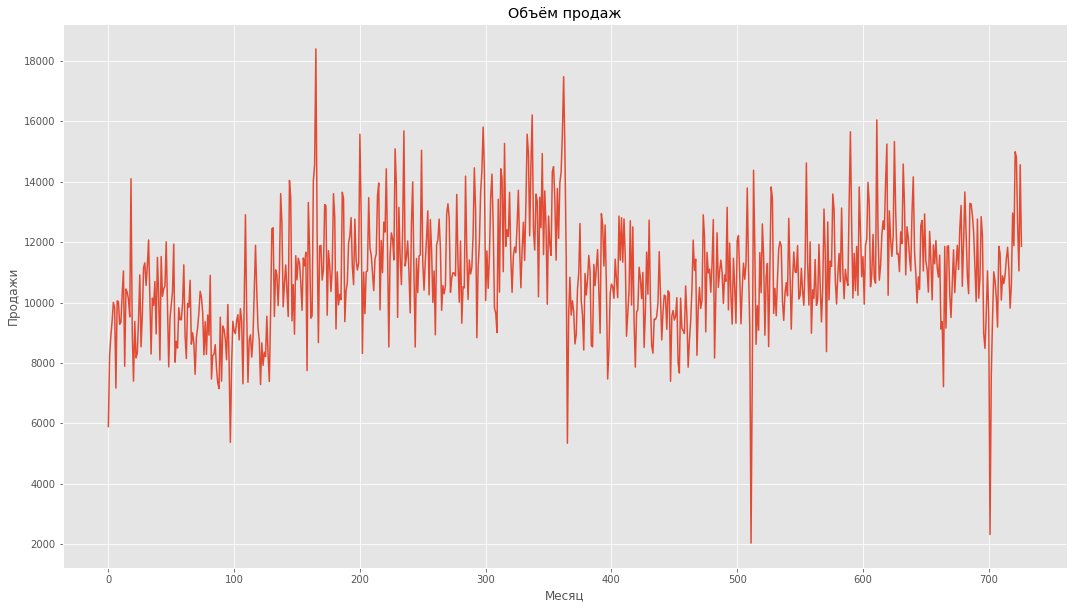

In [3]:
#Построим графики и определим,тип тренда (линейный или нет) и тип сезонности (аддитивный или мультипликативный)
#  Активируем библиотеки, необходимые для работы
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
#  Указываем размер картинки
plt.figure(figsize=(18, 10))
df1=df['y']
df1.plot()
plt.xlabel(u'Месяц')
plt.ylabel(u'Продажи')
plt.title(u'Объём продаж')
plt.show()

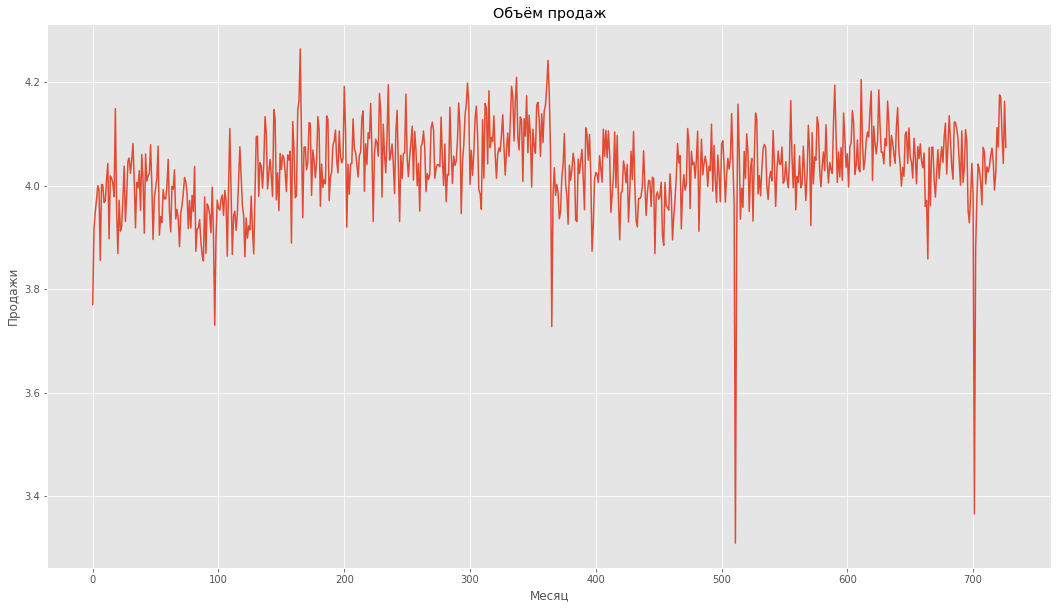

In [4]:
plt.figure(figsize=(18, 10))
df1=df['y']
np.log10(df1).plot()
plt.xlabel(u'Месяц')
plt.ylabel(u'Продажи')
plt.title(u'Объём продаж')
plt.show()

На первом графике виден нелинейный тренд (будто линейно-синусоидальный) и аддитивная сезонность. Так как после добавления графика логарифма, сезонные отклонения не поменялись, то это подтверждает аддитивность.

Ряд не меняет своего характера, имеются выбросы, пропусков не наблюдается.

In [5]:
from fbprophet import Prophet

In [6]:
horizon_ = 60 #на сколько дней прогнозируем
p = Prophet()
p.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [7]:
# Строим прогноз
forecast = p.make_future_dataframe(periods=horizon_)
forecast.tail()

,ds
782,2148-02-25
783,2148-02-26
784,2148-02-27
785,2148-02-28
786,2148-02-29


In [8]:
# предварительная модель
forecast_1 = p.predict(forecast)
forecast_1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
782,2148-02-25,11436.857783,9553.577764,13387.218597
783,2148-02-26,11708.467061,9859.029071,13587.406745
784,2148-02-27,11798.949276,9776.793284,13694.665538
785,2148-02-28,13477.846196,11667.658263,15464.910222
786,2148-02-29,12289.371899,10482.294861,14160.512449


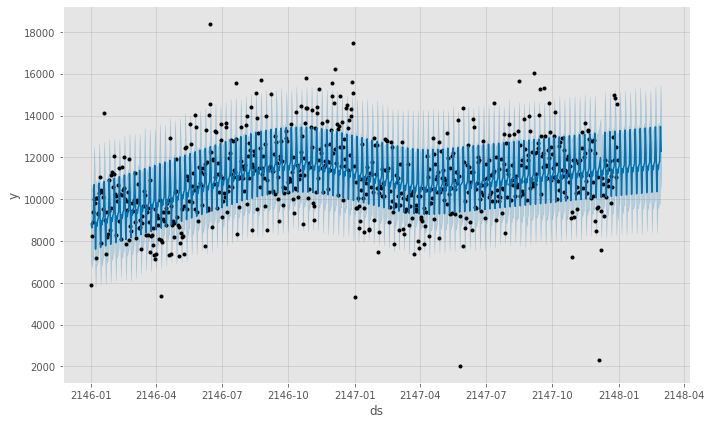

In [9]:
fig1 = p.plot(forecast_1)

In [10]:
# избавляемся от выбросов, с помощью предварительной модели
q1 = df.quantile(0.25)['y']
q3 = df.quantile(0.75)['y']
rng = q3 - q1
hlim = q3 + (1.5 * rng)
llim = q1 - (1.5 * rng)
df['y'] = np.where((df.y > hlim) | (df.y < llim), forecast_1['yhat'][df.index], df.y)

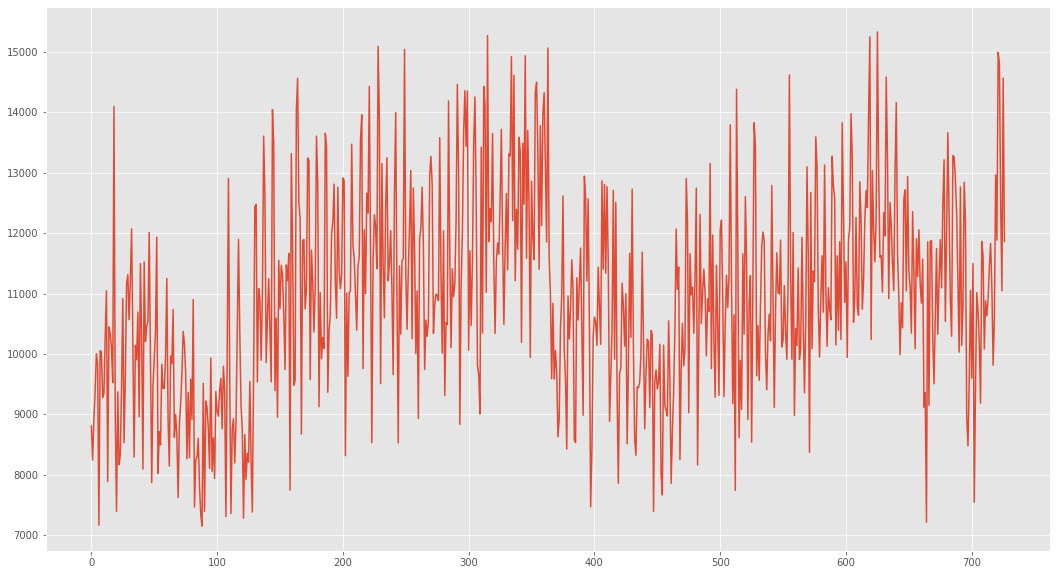

In [11]:
# Строим график без выбросов
plt.figure(figsize=(18,10))
plt.plot(df['y'])

In [12]:
# Разделяем на тренировочную и тестовую выборку
train = df.iloc[:-60]
test = df.iloc[-60:]

In [13]:
#обучаем и прогнозируем опять
p = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
p.fit(train)

In [14]:
forecast = p.make_future_dataframe(periods=60)
forecast = p.predict(forecast)
forecast = forecast[['yhat']]

Text(0.5, 1.0, 'Объём продаж')

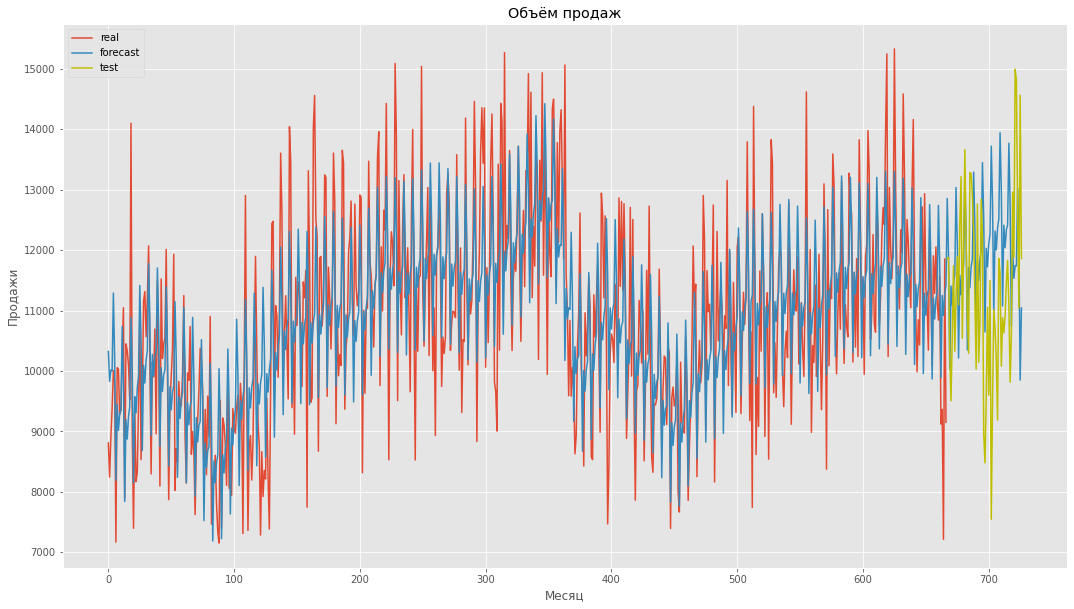

In [15]:
plt.figure(figsize=(18,10))
plt.plot(train['y'], label='real')
plt.plot(forecast, label='forecast')
plt.plot(test['y'], label='test', c='y')
plt.legend()
plt.xlabel('Месяц')
plt.ylabel('Продажи')
plt.title('Объём продаж')

In [16]:
# Оценим качество модели с использованием параметра Mean Absolute Percentage Error
MAPE_FBPROPHET = np.mean(np.abs((forecast['yhat'] - test['y'])/test['y']))*100
print("MAPE for FBPROPHET  = ", MAPE_FBPROPHET)

MAPE for FBPROPHET  =  13.445132162632795


По результатам лабораторной было проведено прогнозирование методом fbprophet на 60 дней. Обучена модель и построен график с исходным рядом и прогнозом, по которому можно сделать вывод, что результат весьма точен. Тот же вывод можно сделать, глядя на значение параметра MAPE.